In [1]:
import earthkit.plots
import earthkit.plots.quickmap
import fcbench
import netCDF4
import xarray as xr

import utils

[pyodide]: Loading numpy, pandas, python-dateutil, pytz, tzdata
[pyodide]: Loaded numpy, pandas, python-dateutil, pytz, tzdata
[pyodide]: Loading Cartopy, Jinja2, MarkupSafe, Pillow, adjustText, affine, array-api-compat, asciitree, attrs, cdsapi, cffi, cfgrib, cftime, click, cligj, cloudpickle, contourpy, cycler, dask, datapi, docstring_parser, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, eccodes, ecmwf-api-client, ecmwf-opendata, entrypoints, field-compression-benchmark, filelock, findlibs, fiona, flexcache, flexparser, fonttools, fsspec, gdal, geopandas, geos, h5py, hda, joblib, jsonschema, jsonschema_specifications, kiwisolver, locket, lru-dict, markdown, matplotlib, matplotlib-pyodide, msgpack, multiurl, netcdf4, numcodecs, openblas, partd, pdbufr, pint, pkgconfig, platformdirs, plotly, polytope-client, pycparser, pyparsing, pyproj, pyrsistent, pyshp, pyyaml, rasterio, refe

Matplotlib is building the font cache; this may take a moment.
/lib/python3.12/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


[pyodide]: Memory usage has grown to 329.6MiB (from 49.9MiB) for this notebook


In [2]:
fcbench.codecs.preload()

Loaded the fcbench.codecs.Asinh codec ...
Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.FixedOffsetScale codec ...
Loaded the fcbench.codecs.FourierNetwork codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.RandomProjection codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.SwizzleReshape codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...


In [3]:
import shutil
from urllib.request import urlopen

with urlopen("https://a3s.fi/compression.lab.climet.eu/era5_t2m_2012_12_01_14:00.nc") as response:
    with open("t2m.nc", "wb") as file:
        shutil.copyfileobj(response, file)

In [4]:
t = xr.open_dataset("t2m.nc").t2m.rename(dict(valid_time="time"))
t

<xarray.DataArray 't2m' (time: 1, latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 8B 2012-12-01T14:00:00
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     <U4 16B ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


[pyodide]: Memory usage has grown to 569.6MiB (from 329.6MiB) for this notebook


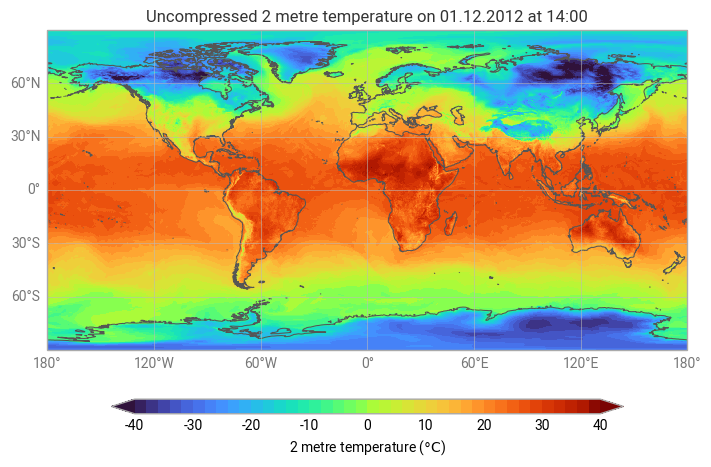

In [5]:
chart = earthkit.plots.quickmap.plot(t, units="degC")
chart.title("Uncompressed {variable_name} on {time:%d.%m.%Y at %H:%M}");

[pyodide]: Memory usage has grown to 762.1MiB (from 569.6MiB) for this notebook


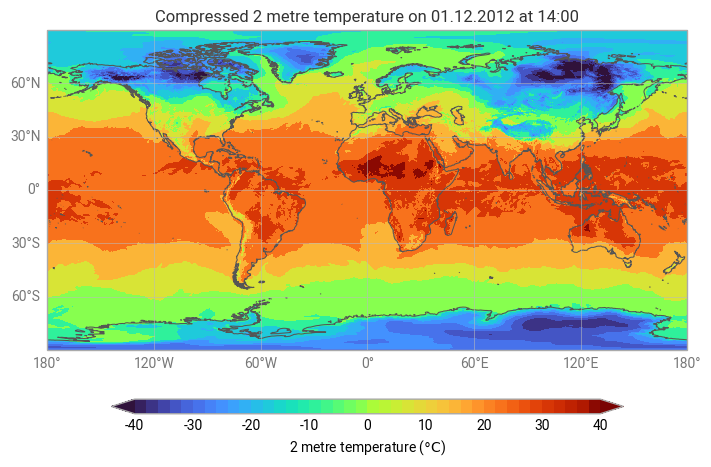

In [6]:
compressor = [
    fcbench.codecs.BitRound(keepbits=5),
    fcbench.codecs.Zlib(level=9),
]

stats = []
t_c = fcbench.compressor.compress_decompress(t, compressor, measurements=stats)

chart = earthkit.plots.quickmap.plot(t_c, units="degC")
chart.title("Compressed {variable_name} on {time:%d.%m.%Y at %H:%M}");

In [7]:
utils.format_compress_stats(compressor, stats)

,compression ratio [raw B / enc B],encode instructions [#/B],decode instructions [#/B]
Codec,,,
BitRound(keepbits=5),1.00,0.3,0.1
Zlib(level=9),74.92,27.5,1.7


[pyodide]: Memory usage has grown to 865.1MiB (from 762.1MiB) for this notebook


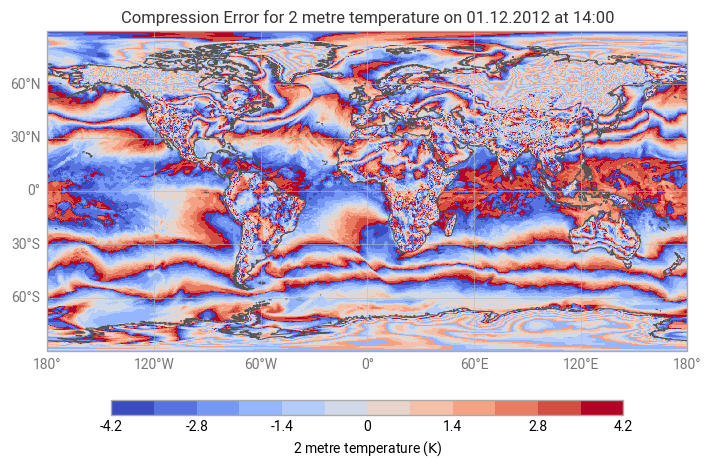

In [8]:
style = earthkit.plots.styles.Style(
    colors="coolwarm",
    levels=earthkit.plots.styles.levels.Levels(divergence_point=0.0),
)

with xr.set_options(keep_attrs=True):
    chart = earthkit.plots.quickmap.plot(t_c - t, style=style);
    chart.title("Compression Error for {variable_name} on {time:%d.%m.%Y at %H:%M}");